In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:

dataset_path = "/kaggle/input/activity-recognition-dataset"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

print("train directory : ", train_dir)
print("test directory : ", test_dir)

train directory :  /kaggle/input/activity-recognition-dataset/train
test directory :  /kaggle/input/activity-recognition-dataset/test


In [ ]:

img_size = (224, 224)
batch_size = 64  

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  
    channel_shift_range=0.2, 
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)

print(num_classes)

Found 10710 images belonging to 15 classes.
Found 1890 images belonging to 15 classes.
15


In [ ]:

base_model = EfficientNetV2B3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

In [ ]:

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True  # ✅ This should NOT be frozen

In [ ]:

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation="relu"), 
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Faster Convergence
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │          15,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,523,981 (55.40 MB)

 Trainable params: 14,412,717 (54.98 MB)

 Non-trainable params: 111,264 (434.62 KB)

In [ ]:
# 4. Callbacks: Reduce LR + Early Stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [11]:
# 🔹 5. Train Model with More Epochs
history = model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=callbacks)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


168/168 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.1391 - loss: 3.3944 - val_accuracy: 0.3915 - val_loss: 2.0668 - learning_rate: 1.0000e-04
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 156s 888ms/step - accuracy: 0.3108 - loss: 2.4769 - val_accuracy: 0.5233 - val_loss: 1.5214 - learning_rate: 1.0000e-04
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 155s 888ms/step - accuracy: 0.4138 - loss: 2.0311 - val_accuracy: 0.4074 - val_loss: 1.9794 - learning_rate: 1.0000e-04
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 156s 889ms/step - accuracy: 0.4711 - loss: 1.7431 - val_accuracy: 0.6106 - val_loss: 1.2444 - learning_rate: 1.0000e-04
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 159s 906ms/step - accuracy: 0.5455 - loss: 1.4885 - val_accuracy: 0.6302 - val_loss: 1.2146 - learning_rate: 1.0000e-04
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 157s 895ms/step - accuracy: 0.5734 - loss: 1.3667 - val_accuracy: 0.5116 - val_loss: 1.5689 - learning_rate: 1.0000e-04
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 156s 890

In [12]:
# 🔹 6. Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"🔹 Updated Test Accuracy: {test_acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8218 - loss: 0.6298
🔹 Updated Test Accuracy: 0.8037


30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 471ms/step


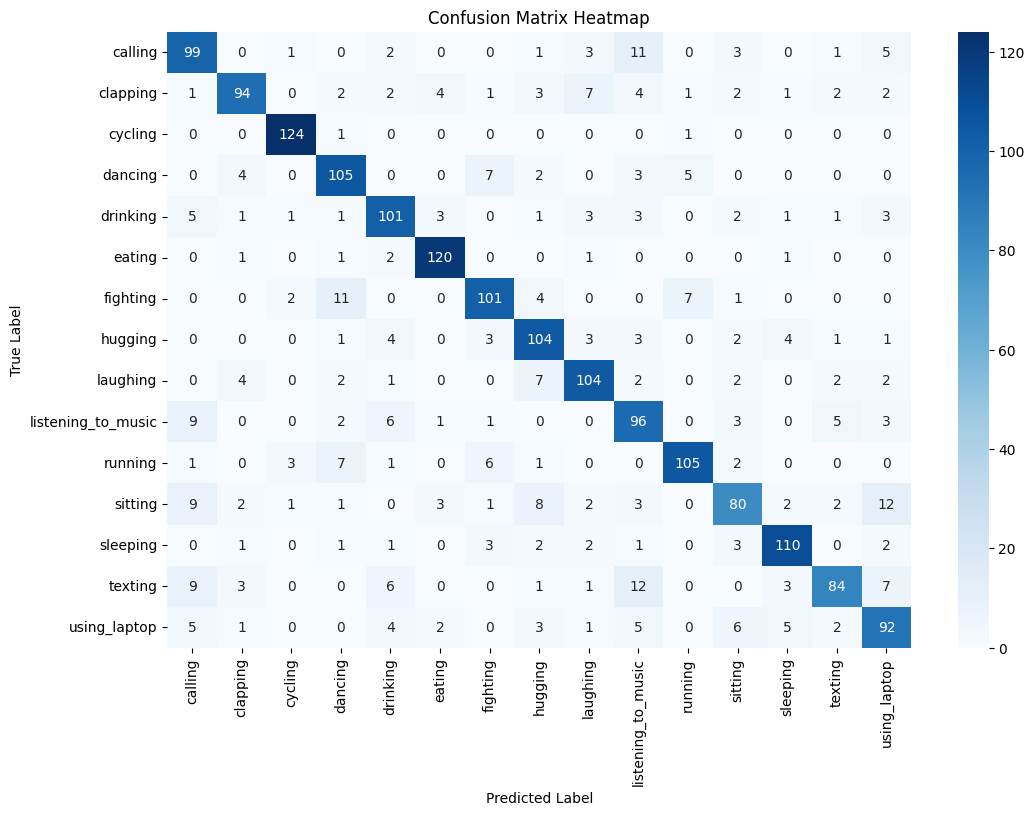

In [13]:
# 🔹 7. Confusion Matrix & Classification Report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [14]:
# ✅ Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Classification Report:
                     precision    recall  f1-score   support

           calling       0.72      0.79      0.75       126
          clapping       0.85      0.75      0.79       126
           cycling       0.94      0.98      0.96       126
           dancing       0.78      0.83      0.80       126
          drinking       0.78      0.80      0.79       126
            eating       0.90      0.95      0.93       126
          fighting       0.82      0.80      0.81       126
           hugging       0.76      0.83      0.79       126
          laughing       0.82      0.83      0.82       126
listening_to_music       0.67      0.76      0.71       126
           running       0.88      0.83      0.86       126
           sitting       0.75      0.63      0.69       126
          sleeping       0.87      0.87      0.87       126
           texting       0.84      0.67      0.74       126
      using_laptop       0.71      0.73      0.72       126

          accu

In [17]:
model.save("activity_recogintion_model.h5")

In [18]:
import json

# Save class indices
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

import pickle

# Save history
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)